<h1> Stacked Auto Encoders 5-14-2016</h1>

Assuming CNN-H1, and the 6 CNNs for the patches have been trained, we can use the weights to get activations for their fc6 layer and train 3 layers of our SAE individually.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

from skimage import io
from skimage.color import rgb2grey
from skimage.transform import resize

from keras import backend as K
from keras.utils import np_utils
from keras.models import model_from_json

np.random.seed(123456)

Using Theano backend.


In [3]:
data_path = '../data/lfw_cropped'
noise_width = 15
num_people = 600
cnn_h1_rows, cnn_h1_cols = 165, 120
cnn_p1_rows, cnn_p1_cols = 100, 100

nn1_model_file = 'NN1_1x100x100_600'
nn2_model_file = 'NN2_1x165x120_600'

cnn_h1_weight_file = 'CNN-H1_epoch-20'
cnn_p1_weight_file = 'CNN-P1_epoch-20'
cnn_p2_weight_file = 'CNN-P2_epoch-20'
cnn_p3_weight_file = 'CNN-P3_epoch-20'
cnn_p4_weight_file = 'CNN-P4_epoch-20'
cnn_p5_weight_file = 'CNN-P5_epoch-20'
cnn_p6_weight_file = 'CNN-P6_epoch-20'

<h2>Loading Files</h2>

In [4]:
def get_face_to_file_path_dict():
    face_to_file_paths_dict = {}
    
    for root, dirnames, filenames in os.walk(data_path):
        for dirname in dirnames:
            if dirname not in face_to_file_paths_dict:
                face_to_file_paths_dict[dirname] = []
            directory_path = os.path.join(data_path, dirname)
            for filename in os.listdir(directory_path):
                if filename.endswith('_image.npy'):
                    face_to_file_paths_dict[dirname].append(os.path.join(directory_path, filename))
                            
    return face_to_file_paths_dict

def get_face_to_file_paths_descending_list(face_to_file_paths_dict):
    return sorted(face_to_file_paths_dict.items(), key=lambda x: len(x[1]), reverse=True)

In [5]:
face_to_file_paths_dict = get_face_to_file_path_dict()
face_to_file_paths_list = get_face_to_file_paths_descending_list(face_to_file_paths_dict)[:num_people]

<h2>Image Pre-Processing</h2>

In [6]:
def reflection(image):
    return np.array([list(reversed(row)) for row in image])

def partition(image, top_left, rows, cols):
    return np.array([row[top_left[1]:top_left[1] + cols] for row in image[top_left[0]:top_left[0] + rows]])

def get_random_noise_image(image, coords, width):
    """
    Apply random gaussian generated values
    and distribute them on gaussian distributed square
    centered on the coordinates passed in for the image
    """
    
    noise = np.zeros((image.shape[0], image.shape[1]))
    for coord in coords:
        # Convert coordinates to rows / columns
        apply_noise_at_point(coord[1], coord[0], noise, width)
    return np.clip(image + noise, 0, 1)

def apply_noise_at_point(x, y, noise, width):
    """
    Generate a block with a single random value placed at the center
    Apply the Gaussian filter with std of 4
    Place it on the noise array at the appropriate coordinates
    
    x represents the rows
    y represents the cols
    """
    
    block = np.zeros((width, width))
    block[width / 2, width / 2] = np.random.normal()
    block = gaussian_filter(block, sigma=4)
    
    x -= width / 2
    y -= width / 2
    
    x_end = min(noise.shape[0] - x, block.shape[0])
    x_start =  max(0, -x)

    y_end = min(noise.shape[1] - y, block.shape[1])
    y_start = max(0, -y)

    noise[max(0, x):x+block.shape[0], max(0, y):y+block.shape[1]] = block[x_start:x_end,y_start:y_end]
    
def apply_noise(image, coords):
    return get_random_noise_image(image, coords, noise_width)

def get_feature_points(f):
    f = f.replace('image', 'features')
    return np.load(f)

def get_landmark_points(f):   
    f = f.replace('image', 'landmarks')
    return np.load(f)

def get_image_window(image, size, point):
    """
    Assume image is grey image
    """
    top = int(point[1] - size[0] / 2)
    left = int(point[0] - size[1] / 2)
    return image[top:top + size[0], left:left + size[1]]

In [7]:
images_by_class = [[(np.load(f), get_landmark_points(f), get_feature_points(f)) 
                    for f in x[1]] for x in face_to_file_paths_list]

In [8]:
# Create reflection with reflected coordinates
for i in range(len(images_by_class)):
    for j in range(len(images_by_class[i])):
        im, landmarks, features = images_by_class[i][j]
        new_features = [(im.shape[1] - p[0], p[1]) for p in features]
        new_landmarks = [(im.shape[1] - p[0], p[1]) for p in landmarks]
        new_landmarks[:3], new_landmarks[6:] = new_landmarks[6:], new_landmarks[:3]
        images_by_class[i].append((reflection(im), new_landmarks, new_features))

In [9]:
# Doubling the images and applying random gaussian noise
for i in range(len(images_by_class)):
    images_by_class[i] += images_by_class[i][:]
    images_by_class[i] = [(apply_noise(im, features), landmarks) 
                          for im, landmarks, features in images_by_class[i]]

<h2>Image Partitioning</h2>

Images are cropped for each CNN, verification of size and shuffling

In [10]:
def get_images(rows, cols, landmark_index):
    temp_images_by_class = [None for _ in range(len(images_by_class))]
    for i in range(len(images_by_class)):
        temp_images_by_class[i] = [get_image_window(im, (rows, cols), landmarks[landmark_index])
                              for im, landmarks in images_by_class[i]]
    images = [image 
            for images in temp_images_by_class 
            for image in images 
            ]
    return images

In [11]:
y_train = [images[0] 
    for images in enumerate(images_by_class) 
    for image in images[1] 
]

In [12]:
images_h1 = get_images(cnn_h1_rows, cnn_h1_cols, 4)
images_p1 = get_images(cnn_p1_rows, cnn_p1_cols, 0)
images_p2 = get_images(cnn_p1_rows, cnn_p1_cols, 1)
images_p3 = get_images(cnn_p1_rows, cnn_p1_cols, 2)
images_p4 = get_images(cnn_p1_rows, cnn_p1_cols, 3)
images_p5 = get_images(cnn_p1_rows, cnn_p1_cols, 4)
images_p6 = get_images(cnn_p1_rows, cnn_p1_cols, 5)

In [13]:
zipped = np.array(zip(images_h1, 
                      images_p1,
                      images_p2,
                      images_p3,
                      images_p4,
                      images_p5,
                      images_p6,
                      y_train))

In [14]:
len(zipped)

26688

In [15]:
zipped = [images 
    for images in zipped  
    if images[0].shape == (cnn_h1_rows, cnn_h1_cols)
          and images[1].shape == (cnn_p1_rows, cnn_p1_cols)
          and images[2].shape == (cnn_p1_rows, cnn_p1_cols)
          and images[3].shape == (cnn_p1_rows, cnn_p1_cols)
          and images[4].shape == (cnn_p1_rows, cnn_p1_cols)
          and images[5].shape == (cnn_p1_rows, cnn_p1_cols)
          and images[6].shape == (cnn_p1_rows, cnn_p1_cols)
    ]

In [16]:
len(zipped)

26668

In [17]:
np.random.shuffle(zipped)

In [18]:
X_train_h1 = np.array([x[0] for x in zipped])
X_train_p1 = np.array([x[1] for x in zipped])
X_train_p2 = np.array([x[2] for x in zipped])
X_train_p3 = np.array([x[3] for x in zipped])
X_train_p4 = np.array([x[4] for x in zipped])
X_train_p5 = np.array([x[5] for x in zipped])
X_train_p6 = np.array([x[6] for x in zipped])
y_train = np.array([x[7] for x in zipped])

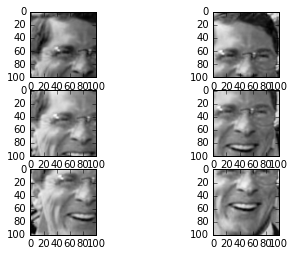

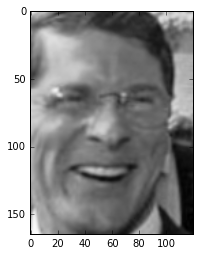

In [19]:
# Validating faces are correct
i = 9000
fig, ax = plt.subplots(nrows=3, ncols=2)

ax[0][0].imshow(X_train_p1[i], cmap='Greys_r')
ax[1][0].imshow(X_train_p2[i], cmap='Greys_r')
ax[2][0].imshow(X_train_p3[i], cmap='Greys_r')
ax[0][1].imshow(X_train_p4[i], cmap='Greys_r')
ax[1][1].imshow(X_train_p5[i], cmap='Greys_r')
ax[2][1].imshow(X_train_p6[i], cmap='Greys_r')
plt.show()
plt.imshow(X_train_h1[i], cmap='Greys_r')
plt.show()

In [20]:
def get_reshaped_training_set(X_train):
    return X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])

In [21]:
X_train_h1 = get_reshaped_training_set(X_train_h1)
X_train_p1 = get_reshaped_training_set(X_train_p1)
X_train_p2 = get_reshaped_training_set(X_train_p2)
X_train_p3 = get_reshaped_training_set(X_train_p3)
X_train_p4 = get_reshaped_training_set(X_train_p4)
X_train_p5 = get_reshaped_training_set(X_train_p5)
X_train_p6 = get_reshaped_training_set(X_train_p6)

Y_train = np_utils.to_categorical(y_train, len(images_by_class))

In [22]:
print X_train_h1.shape
print X_train_p1.shape
print X_train_p2.shape
print X_train_p3.shape
print X_train_p4.shape
print X_train_p5.shape
print X_train_p6.shape

(26668, 1, 165, 120)
(26668, 1, 100, 100)
(26668, 1, 100, 100)
(26668, 1, 100, 100)
(26668, 1, 100, 100)
(26668, 1, 100, 100)
(26668, 1, 100, 100)


<h2>Loading Models</h2>

In [23]:
def load_model(model_file, weight_file):
    model = None
    with open('models/' + model_file + '.json','r') as f:
        model = model_from_json(f.read())
    model.load_weights('models/' + weight_file + '.h5')
    return model

In [24]:
cnn_h1 = load_model(nn2_model_file, cnn_h1_weight_file)
cnn_p1 = load_model(nn1_model_file, cnn_p1_weight_file)
cnn_p2 = load_model(nn1_model_file, cnn_p2_weight_file)
cnn_p3 = load_model(nn1_model_file, cnn_p3_weight_file)
cnn_p4 = load_model(nn1_model_file, cnn_p4_weight_file)
cnn_p5 = load_model(nn1_model_file, cnn_p5_weight_file)
cnn_p6 = load_model(nn1_model_file, cnn_p6_weight_file)

In [25]:
print len(cnn_h1.layers)
print len(cnn_p1.layers)
print len(cnn_p2.layers)
print len(cnn_p3.layers)
print len(cnn_p4.layers)
print len(cnn_p5.layers)
print len(cnn_p6.layers)

31
27
27
27
27
27
27


<h2>Creating Activations for each layer</h2>

In [26]:
def get_activations(model, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], model.layers[-2].output)
    activations = get_activations([X_batch,0])
    return activations

In [27]:
activations_h1 = get_activations(cnn_h1, X_train_h1)

MemoryError: alloc failed
Apply node that caused the error: Alloc(TensorConstant{0.0}, Shape_i{0}.0, TensorConstant{128}, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0)
Toposort index: 54
Inputs types: [TensorType(float32, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(), (), (), (), ()]
Inputs strides: [(), (), (), (), ()]
Inputs values: [array(0.0, dtype=float32), array(26668), array(128), array(22), array(16)]
Outputs clients: [[IncSubtensor{InplaceSet;::, ::, int64:int64:, int64:int64:}(Alloc.0, Pool{ds=(2, 2), ignore_border=True, st=(2, 2), padding=(0, 0), mode='max'}.0, Constant{1}, ScalarFromTensor.0, Constant{1}, ScalarFromTensor.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/layer_utils.py", line 35, in layer_from_config
    return layer_class.from_config(config['config'])
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 767, in from_config
    model.add(layer)
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 146, in add
    output_tensor = layer(self.outputs[0])
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 485, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 543, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 148, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional.py", line 1191, in call
    dim_ordering=self.dim_ordering)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/theano_backend.py", line 421, in spatial_2d_padding
    output = T.zeros(output_shape)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
cnn_h1.predict(X_train_h1)

In [ ]:
activations_p1 = get_activations(cnn_p1, X_train_p1)
activations_p2 = get_activations(cnn_p2, X_train_p2)
activations_p3 = get_activations(cnn_p3, X_train_p3)
activations_p4 = get_activations(cnn_p4, X_train_p4)
activations_p5 = get_activations(cnn_p5, X_train_p5)
activations_p6 = get_activations(cnn_p6, X_train_p6)